In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm
import math

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd

Using TensorFlow backend.


In [2]:
ctx = straxbra.XebraContext()

In [3]:
run = '00192'
peaks_data = ctx.get_array(run, 'peaks')

In [4]:
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5]
timestamp = peaks_data['time']
area_per_channel = peaks_data['area_per_channel']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]

In [5]:
def CutCondition(waveform):
    
    
    FirstPeak_area = sum(waveform[:15]) # range in samples (not ns!)
    SecondPeak_area = sum(waveform[15:]) # range in samples (not ns!)

    
    if  FirstPeak_area > 100 and FirstPeak_area < 600 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
#        print (i , secondS1_area, secondS1_peaktime)
        return(True)
    else:
        return(False)
    

In [6]:
def PrintWaveform(waveform,i):

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12, 3.5))

    ax1.plot(waveform[i])
    ax2.plot(waveform[i+1])
#     ax1.set_xlim([0, 50])
    plt.show()


In [7]:
def S2_found(integral, width):
    if integral > 500 and width >200 and width < 2000:
        return True
    else:
        return False

In [8]:
def Process(waveform, i):
    CutFlag = CutCondition(waveform[i])
    if CutFlag == True:
        Timestamps_kr_events.append(timestamp[i])
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 65000
        while threshold_timestamp >= counter_timestamp and S2_found(integral = integral[i+j], width = width[i+j]) == False: 
            j += 1
            counter_timestamp = timestamp[i+j]           
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):
                    #PrintWaveform(waveform[i+j])
                kr_s2_area.append(integral[i+j])
                kr_s2_width.append(width[i+j])
                kr_s2_risetime.append(risetime[i+j])
                kr_s2_drifttime.append(counter_timestamp - timestamp[i])
                    
                return
            else:
                return

In [9]:
num = len(waveform)

kr_s2_area = []
kr_s2_width = []
kr_s2_risetime = []
kr_s2_drifttime = []
Timestamps_kr_events = []
Time_between_S1 = []
print_counter = 0.0
for i in range(0,num):
    
    Process(waveform,i)
    
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
        
print(1.0)

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0


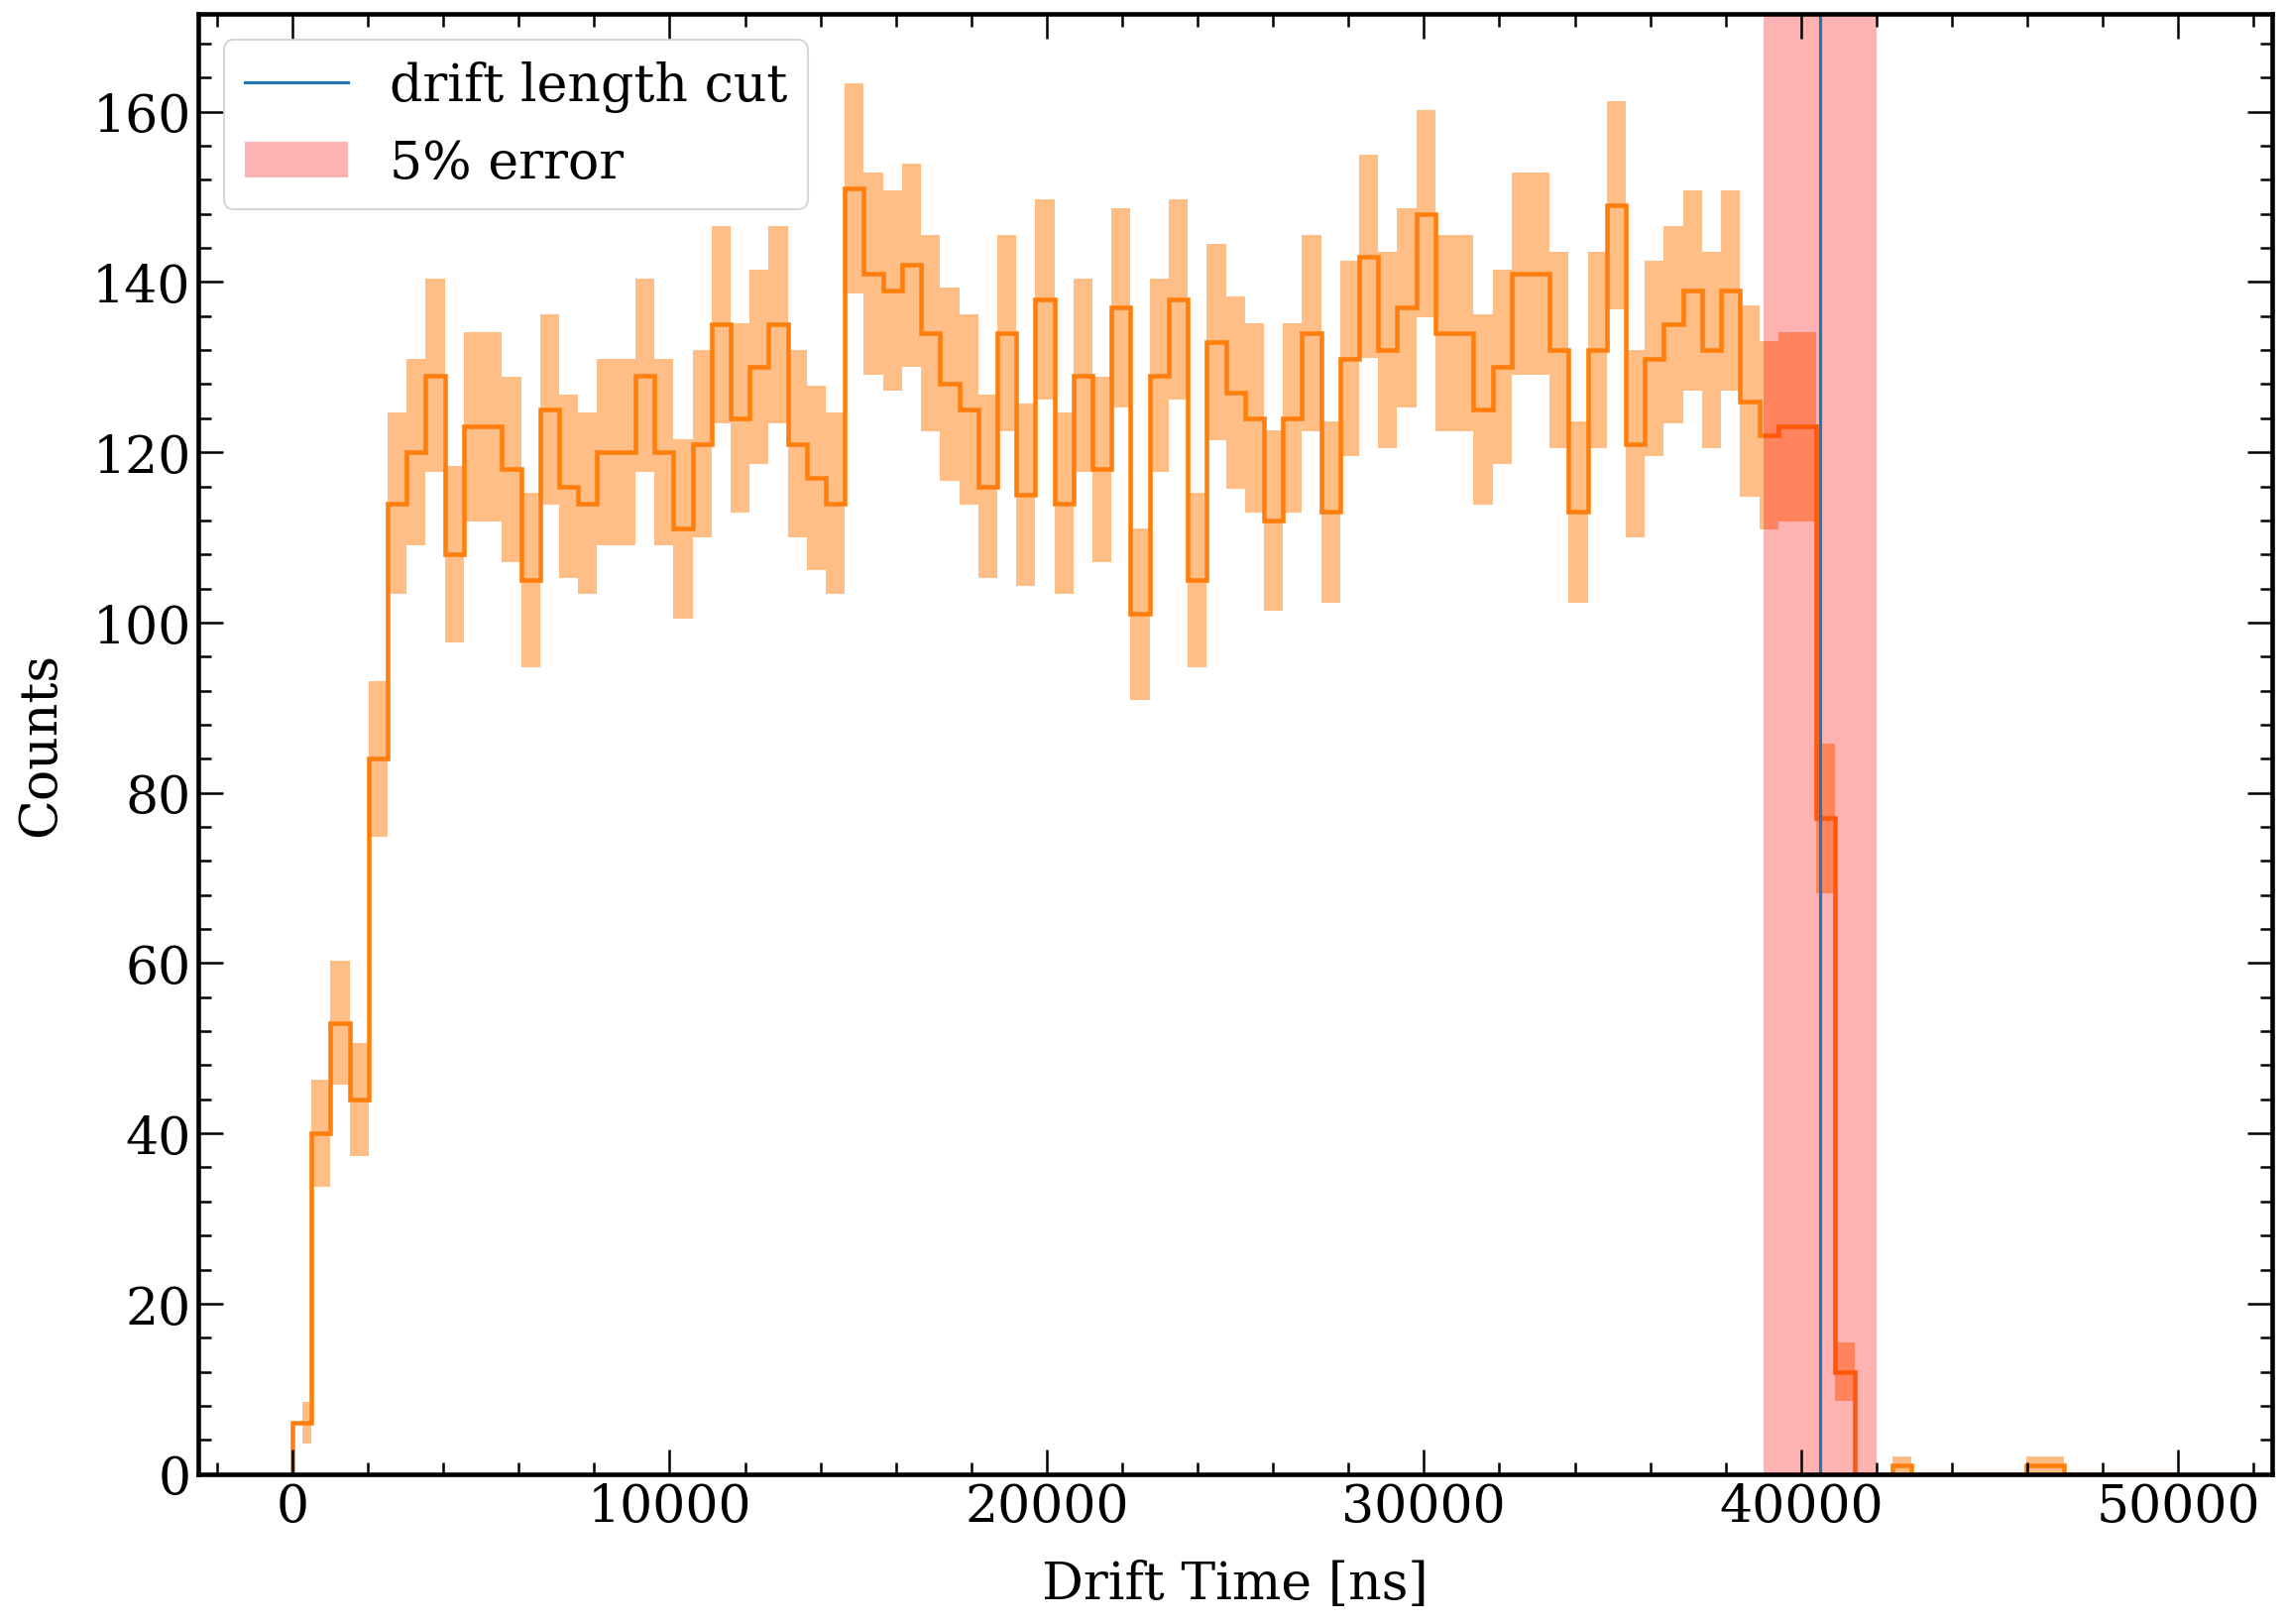

In [10]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(18, 13), dpi=150)

# Text options
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################




# Data plot
time_limit = 50000 # 65000 for E_D = 50 V/cm

bins = 100
#bins_x = np.linspace(45000,50000,bins)
bins_x = np.linspace(0,time_limit,bins)
bins_x_center = (bins_x[1:] + bins_x[:-1])/2
bin_fullwidths = (bins_x[1:] - bins_x[:-1])

counts,_, patches = plt.hist(kr_s2_drifttime, bins=bins_x, density = False, 
                             histtype='step', linewidth = 2.2, color = 'C1')


plt.fill_between(bins_x_center, counts - np.sqrt(counts), counts + np.sqrt(counts), 
                 facecolor='C1', alpha=0.5, step = 'mid')
axes.axvspan(39000,42000,facecolor='r', alpha = 0.3, label = '5% error')
axes.axvline(40500,0, 200, alpha = 1, label = 'drift length cut' )
plt.xlabel('Drift Time [ns]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

#plt.xlim(50000, 60000)
plt.ylim(bottom = 0)

'''# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)'''

#fig.savefig(filenameprefix+"_drifttime.png")
plt.legend(loc =2, prop = {'size':25})
plt.show()

In [11]:
1500/40500

0.037037037037037035

[0.75004076 0.1387221 ]


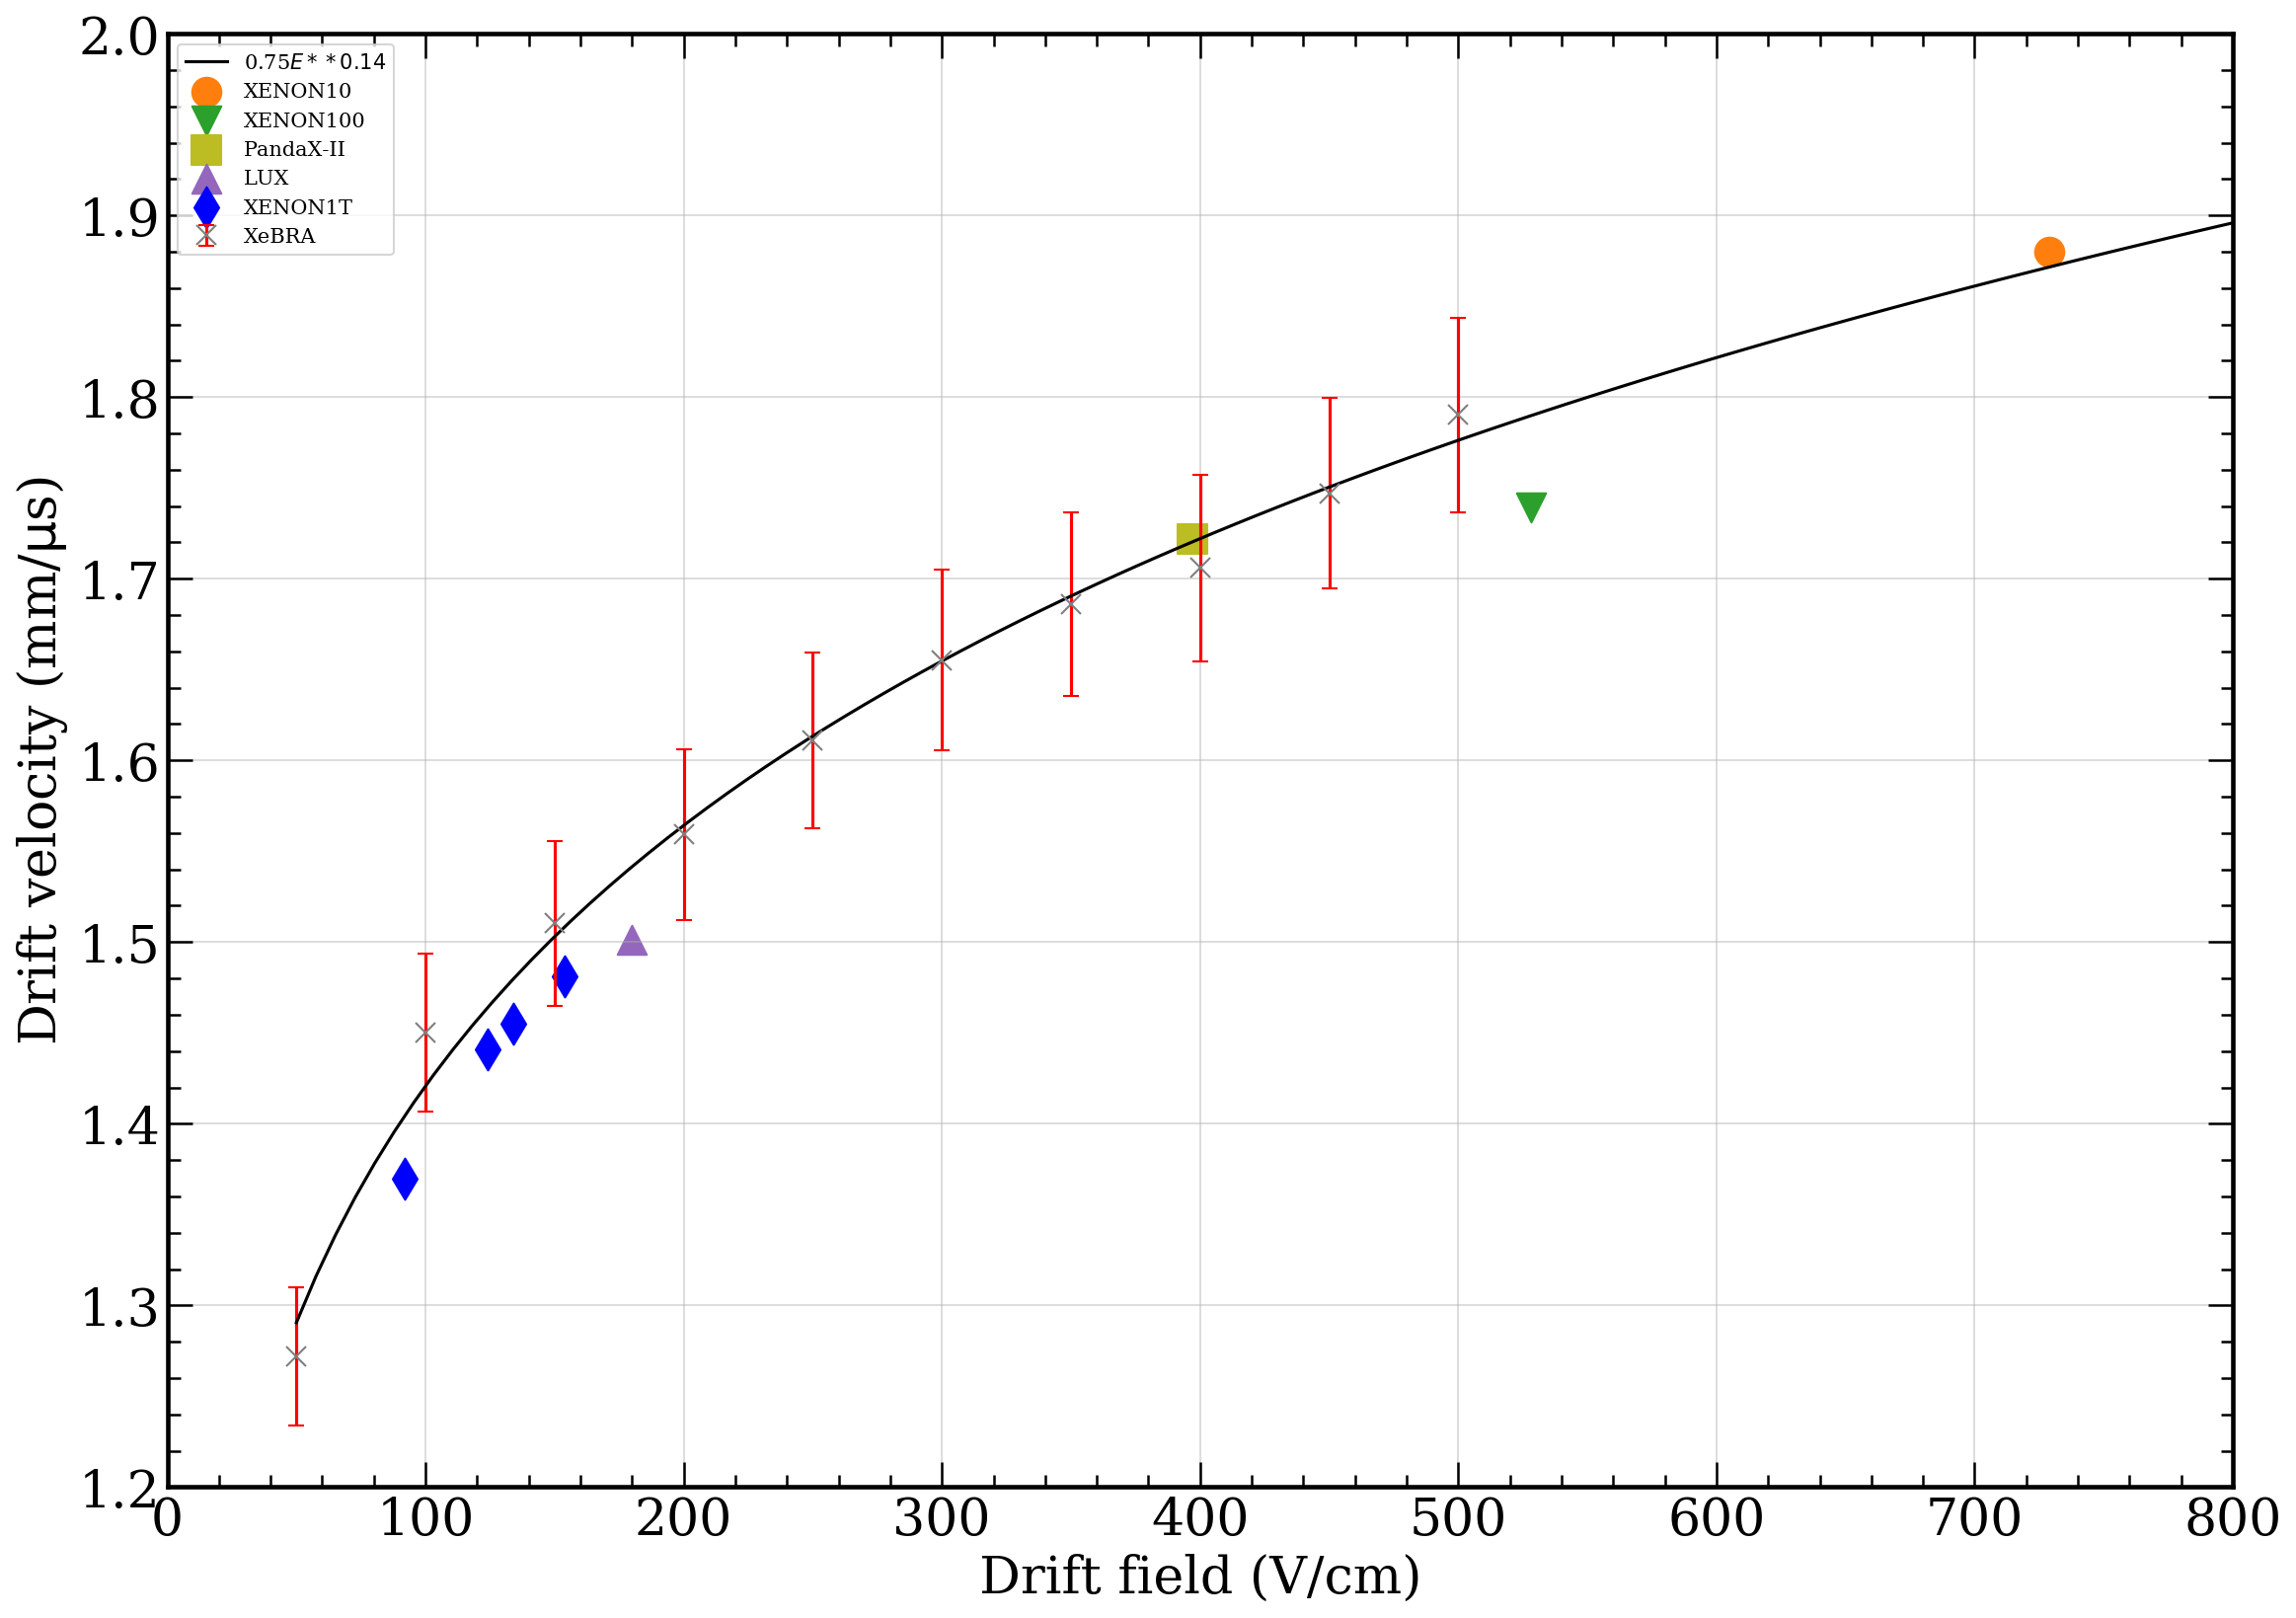

In [22]:
def power_law(x,a,b):
    power_law = a*x**b
    return power_law

p0 = [0.7,0.1]
fig=plt.figure(figsize=(18, 13), dpi=150)
plt.rc('font', family='serif')
SIZE = 25
EXTRA_SIZE = 30

plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
# plt.rc('legend', fontsize=25)    # legend fontsize
# plt.rc('figure', titlesize=SIZE)



# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

Drift_field_range = np.linspace(50,800,100)
Drift_field = [500,450,400,350,300,250,200,150,100,50]
Drift_time_list = np.array([40500,41500,42500,43000,43800,45000,46500,48000,50000,57000])*1e-3
Drift_time_list_error = np.array([40500,41500,42500,43000,43800,45000,46500,48000,50000,57000])*1e-3*0.05

Xenon10_v = 1.880
Xenon100_v = 1.739
PandaXII_v = 1.722
Lux_v = 1.501
Xenon1T_v = [1.370,1.441,1.455,1.481]

Xenon10_field = 729
Xenon100_field = 528
PandaXII_field = 397
Lux_field = 180
Xenon1T_field = [92,124,134,154]


Drift_velocity_list = 72.5/np.array(Drift_time_list)
Drift_velocity_list_error = 72.5/np.array(Drift_time_list)*0.03

popt, pcov  = curve_fit(power_law, Drift_field, Drift_velocity_list, p0=p0, sigma=np.maximum(np.sqrt(Drift_velocity_list), np.ones_like(Drift_velocity_list)))
print(popt)


axes.errorbar(Drift_field,Drift_velocity_list,yerr=Drift_velocity_list_error,marker = 'x',fmt='.', c = 'C7',markersize='10', ecolor='red',capsize=4, label = 'XeBRA')

axes.scatter(Xenon10_field, Xenon10_v, marker = 'o', s=200, c = 'C1', label = 'XENON10')
axes.scatter(Xenon100_field, Xenon100_v, marker = 'v', s=200, c = 'C2', label = 'XENON100')
axes.scatter(PandaXII_field, PandaXII_v, marker = 's', s=200, c = 'C8', label = 'PandaX-II')
axes.scatter(Lux_field, Lux_v, marker = '^', s=200, c = 'C4', label = 'LUX')
axes.scatter(Xenon1T_field, Xenon1T_v, marker = 'd', s=200, c = 'b', label = 'XENON1T')

axes.plot(Drift_field_range,power_law(Drift_field_range,*popt), color = 'k', label = f'{popt[0]:0.2f}$E**{popt[1]:0.2f}$')
#axes.scatter(Drift_field_experiments, Drift_velocity_experiments, marker = 'o', s=200)
#axes.plot(x,y)
#axes.set_yscale('log')
#axes.set_xscale('log')
axes.set_ylabel('Drift velocity (mm/$\mathrm{\mu}$s)')
axes.set_xlabel('Drift field (V/cm)')
plt.ylim(1.2, 2)
plt.xlim(0, 800)
plt.grid(alpha = 0.5)
plt.legend(loc =2)
plt.show()

In [13]:
Average_time_kr_S1 = [j-i for i, j in zip(Timestamps_kr_events[:-1], Timestamps_kr_events[1:])]

max(Average_time_kr_S1)

132005830

[422 413 392 383 393 344 348 306 316 288 260 282 269 272 238 251 235 227
 206 203 203 193 161 165 192 167 140 182 152 119 128 132 145 142 127 118
  94 116 101 107  83  99  79  86  87  75  73  83  80  82  73  58  70  52
  48  67  51  46  51  52  48  40  47  45  39  39  37  27  24  35  23  31
  40  37  27  29  21  18  24  22  20  17  21  15  12  22  19  20  18  18
  15  11  15   9  12  11  11  18   9]
[4.29498283e+02 7.41712656e-08]
9345225.20819151


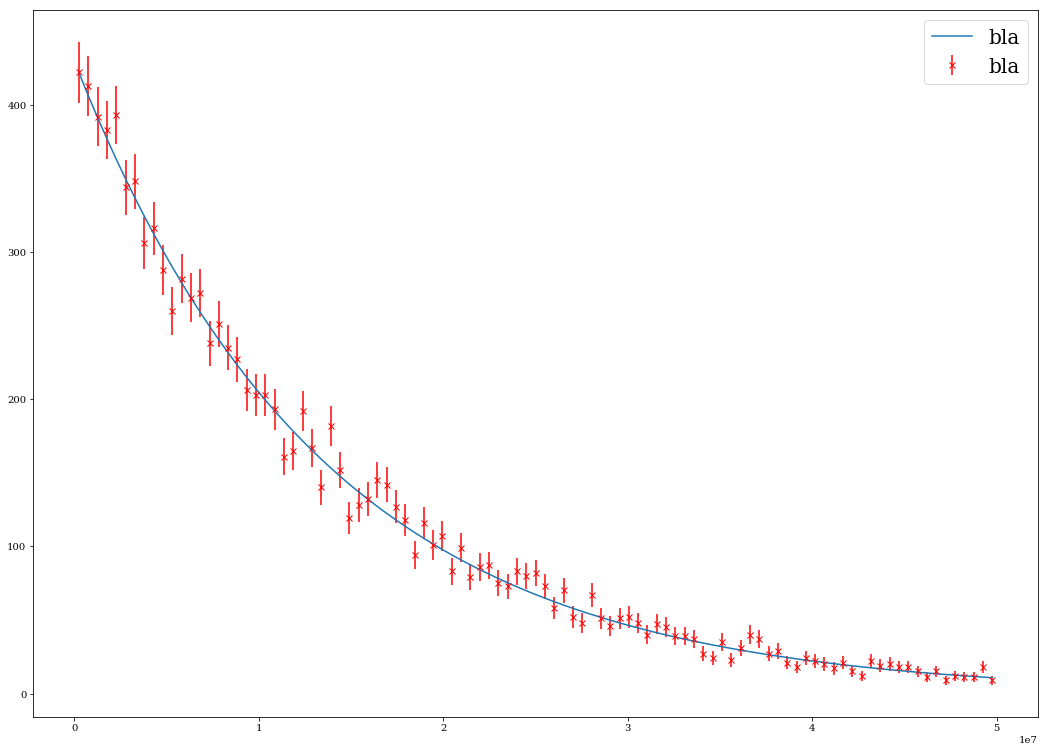

In [14]:
fig, ax = plt.subplots(figsize=(18,13))
def expo(x,a,b):
    expo = a*np.exp(-b*x)
    return expo

p0= [1000,1e-7]
#bounds = ((0, 0),(np.inf, np.inf ))
hist_max = 0.6e8
hist_min = 0.01e8

bins = np.linspace(0, 5e7, 100)
Time_between_krS1, binEdges = np.histogram(Average_time_kr_S1, bins=bins)
#Time_between_krS1 = np.array(Time_between_krS1)/1e9
bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
print(Time_between_krS1)
popt, pcov = curve_fit(expo, bincenters, Time_between_krS1, p0=p0, sigma = np.sqrt(Time_between_krS1), maxfev =10000)
plt.plot(bincenters, expo(bincenters, *popt), label = 'bla')
plt.errorbar(bincenters, Time_between_krS1, yerr=np.sqrt(Time_between_krS1), fmt = 'rx', label = 'bla' )
plt.legend(prop={'size': 20})
print(popt)
print(1/popt[1]*np.log(2))
plt.show()
